## Import Modules

In [75]:
import pandas as pd
import numpy as np

import torch
from ultralytics import settings
from ultralytics import YOLO

import os
import json

from pathlib import Path
import shutil
from tqdm.auto import tqdm
import yaml
from concurrent.futures import ThreadPoolExecutor, as_completed
max_workers=12

import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches






# Module Config

In [39]:
# Ultralytics settings
print(settings) 

# GPU Utilisation
print(torch.cuda.is_available())
device = torch.device("cuda")

{'settings_version': '0.0.4', 'datasets_dir': 'D:\\Tom\\GitHub\\Third Year Project\\datasets', 'weights_dir': 'D:\\Tom\\GitHub\\Third Year Project\\Intruder-Aircraft-Detection\\weights', 'runs_dir': 'D:\\Tom\\GitHub\\Third Year Project\\Intruder-Aircraft-Detection\\runs', 'uuid': 'fdb5c10788ffaa41a9047dc764dd8a0a3287d6bec12c0c66234ac745c0366efa', 'sync': True, 'api_key': '', 'openai_api_key': '', 'clearml': True, 'comet': True, 'dvc': True, 'hub': True, 'mlflow': True, 'neptune': True, 'raytune': True, 'tensorboard': True, 'wandb': True}
True


## Load Dataset

In [44]:
# Load Dataset

# Base paths for the images and labels
train_images_path = 'datasets/AVOIDDS/images/train'
train_labels_path = 'datasets/AVOIDDS/labels/train'
val_images_path = 'datasets/AVOIDDS/images/valid'
val_labels_path = 'datasets/AVOIDDS/labels/valid'

# Load the metadata
metadata_path = 'datasets/AVOIDDS/metadata.json'
with open(metadata_path, 'r') as file:
    metadata = json.load(file)

# Function to create a DataFrame from images and labels
def create_dataframe(images_path, labels_path, metadata):

    # List all files in the directories
    image_files = [f for f in sorted(os.listdir(images_path)) if f.endswith('.jpg')]
    label_files = [f for f in sorted(os.listdir(labels_path)) if f.endswith('.txt')]
    
    # Create tempory DataFrame so that final dataframe is in correct order
    temp_df = pd.DataFrame({
        'image_path': [str(images_path + '/' + file) for file in image_files],
        'label_path': [str(labels_path + '/' + file) for file in label_files],
    })

    # Extract image indices to match with metadata
    df = pd.DataFrame()
    df['imageID'] = temp_df['image_path'].apply(lambda x: int(os.path.splitext(os.path.basename(x))[0]))

    # Add image and label paths to final dataframe
    df['image_path'] = temp_df['image_path']
    df['label_path'] = temp_df['label_path']
 
    # Add metadata to each image entry
    for key, value in metadata.items():
        if '.' in key:  # Key represents a range
            start, end = map(int, key.split('.'))
            df.loc[df['imageID'].between(start, end), 'metadata'] = json.dumps(value)

    # Convert the JSON strings in 'metadata' to dictionaries
    df['metadata'] = df['metadata'].apply(json.loads)

    # Expand the 'metadata' column into separate columns
    metadata_df = pd.json_normalize(df['metadata'])
    
    # Concatenate the expanded metadata back to the original DataFrame
    full_df = pd.concat([df.drop(['metadata'], axis=1), metadata_df], axis=1)

    return full_df

# Create the DataFrames for the train and validation sets
train_df = create_dataframe(train_images_path, train_labels_path, metadata)
valid_df = create_dataframe(val_images_path, val_labels_path, metadata)

#train_df.info()

# Create sub datasets

In [45]:
# create sub datasets

# removes all files and folders from dataset directory
def clear_directory(dir_path):    
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)


## creates subsets of main dataset
def create_dataset(dataset_name, filtered_train_df, filtered_valid_df, class_names=['aircraft'], dataset_dir="datasets/"):
    new_dataset_dir = Path(dataset_dir) / dataset_name
    images_dir = Path(new_dataset_dir) / 'images'
    labels_dir = Path(new_dataset_dir) / 'labels'

    # Clear directories if they exist, to overwrite the dataset
    for subdir in ['train', 'valid']:
        img_subdir = images_dir / subdir
        label_subdir = labels_dir / subdir
        if img_subdir.exists():
            clear_directory(img_subdir)
        else:
            img_subdir.mkdir(parents=True, exist_ok=True)
        if label_subdir.exists():
            clear_directory(label_subdir)
        else:
            label_subdir.mkdir(parents=True, exist_ok=True)

    # Create directories
    for subdir in ['train', 'valid']:
        (images_dir / subdir).mkdir(parents=True, exist_ok=True)
        (labels_dir / subdir).mkdir(parents=True, exist_ok=True)

    def copy_file(src, dest):
        shutil.copy2(src, dest)

    def copy_files_concurrently(df, img_dest_dir, label_dest_dir):
        with ThreadPoolExecutor() as executor:
            # Prepare futures for image and label copying
            futures = [executor.submit(copy_file, row['image_path'], img_dest_dir / f"{Path(row['image_path']).name}") for _, row in df.iterrows()]
            futures += [executor.submit(copy_file, row['label_path'], label_dest_dir / f"{Path(row['label_path']).name}") for _, row in df.iterrows()]
            
            # Initialize progress bar
            pbar = tqdm(total=len(futures), desc='Copying files')
            for future in as_completed(futures):
                # Update progress bar upon task completion
                pbar.update(1)
            pbar.close()

    print("Copying training files:")
    copy_files_concurrently(filtered_train_df, images_dir / 'train', labels_dir / 'train')
    print("Copying validation files:")
    copy_files_concurrently(filtered_valid_df, images_dir / 'valid', labels_dir / 'valid')

    # Construct the YAML content with the desired structure
    yaml_content = {
        'path': str(f'../{new_dataset_dir}').replace('\\', '/'),  # Ensuring forward slashes
        'train': str('images/train'),
        'val': str('images/valid'),
        'names': {index: name for index, name in enumerate(class_names)}
    }  

    yaml_path = new_dataset_dir / f"{dataset_name}.yaml"
    with open(yaml_path, 'w') as file:
        yaml.dump(yaml_content, file, sort_keys=False)

    print(f"Dataset '{dataset_name}' created at {dataset_dir}")



In [46]:
# TEST - cessna only dataset test

test_train_df = train_df[train_df['ac'] == 'Cessna Skyhawk']
test_valid_df = valid_df[valid_df['ac'] == 'Cessna Skyhawk']

dataset_name = 'cessna_only'

create_dataset(dataset_name, test_train_df, test_valid_df)

Copying training files:


Copying files:   0%|          | 0/43200 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/4800 [00:00<?, ?it/s]

Dataset 'cessna_only' created at datasets/


# Augmentation Methods

In [47]:
# load and format labels

# extracts class names and bboxes from all objects in label
def load_yolo_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
        bboxes = [list(map(float, label[1:])) for label in labels]
        class_labels = [int(label[0]) for label in labels]
    return bboxes, class_labels

# takes class names and augmented bbox and converts into yolo label format
def format_yolo_label(class_labels, augmented_bboxes):
    label_str = ""
    for class_label, bbox in zip(class_labels, augmented_bboxes):
        label_str += f"{class_label} " + " ".join(f"{x:.6f}" for x in bbox) + "\n"
    return label_str

In [48]:
# clamp bbox

# method to prevent augmented bbox exceeding image boundaries
def clamp_bbox_values(bbox):

    x_min, y_min, x_max, y_max = bbox  # Extract bbox coordinates
    
    # Clamp values to be within [0, 1]
    x_min = max(0.0, min(x_min, 1.0))
    y_min = max(0.0, min(y_min, 1.0))
    x_max = max(0.0, min(x_max, 1.0))
    y_max = max(0.0, min(y_max, 1.0))
    
    # Make sure that min values are less than max values
    x_min, x_max = min(x_min, x_max), max(x_min, x_max)
    y_min, y_max = min(y_min, y_max), max(y_min, y_max)

    return (x_min, y_min, x_max, y_max)

In [49]:
# TEST - clamp

bbox = [0.7,-0.5,1.2,1]

clamp_bbox_values(bbox)

(0.7, 0.0, 1.0, 1)

In [88]:
## horizontal/vertical flip

def augment_flip(image_path, label_path, orientation, p=1.0):
    # Load image - openCV
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load labels
    bboxes, class_labels = load_yolo_labels(label_path)
    
    # Define the augmentation based on the orientation parameter
    if orientation == 'h':
        flip = A.HorizontalFlip(p=p)
    elif orientation == 'v':
        flip = A.VerticalFlip(p=p)
    else:
        raise ValueError("Orientation must be 'h' or 'v'")
    
    transform = A.Compose([
        flip,
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    # Apply transformation
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    augmented_image = transformed['image']
    augmented_bboxes = transformed['bboxes']

    
    # YOLO formatted label: [class_id, x_center, y_center, width, height]
    augmented_label = format_yolo_label(class_labels, augmented_bboxes)
    
    return augmented_image, augmented_label

In [51]:
## rotation

def augment_rotation(image_path, label_path, angle, p=1.0):
   
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load labels
    bboxes, class_labels = load_yolo_labels(label_path)
    
    # Define the augmentation with rotation
    transform = A.Compose([
        A.Rotate(limit=(angle, angle), p=p, border_mode=cv2.BORDER_CONSTANT),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    # Apply transformation
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    augmented_image = transformed['image']
    augmented_bboxes = transformed['bboxes']
    

    # Convert augmented bboxes and class labels back to YOLO format
    augmented_label = format_yolo_label(class_labels, augmented_bboxes)
    
    return augmented_image, augmented_label

In [52]:
# contrast and brightness

# Alpha - contrast control (1.0-3.0)
# Beta - brightness control (-100 to 100)
def augment_brightness_contrast(image_path, alpha=1.0, beta=0):
    
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply brightness and contrast adjustment
    augmented_image = np.clip(alpha * image.astype(np.float32) + beta, 0, 255).astype(np.uint8)
    
    return augmented_image

In [53]:
# histogram equalisation with CLAHE

def augment_histogram_equalization(image_path, p=1.0):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Define the augmentation
    transform = A.Compose([
        A.CLAHE(p),
    ])
    
    # Apply the augmentation
    transformed = transform(image=image)
    augmented_image = transformed['image']
    
    return augmented_image

In [54]:
# white balancing - gray word algorithm

def augment_white_balance(image_path):
  
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate the mean of each channel
    mr = np.mean(image[:, :, 0])
    mg = np.mean(image[:, :, 1])
    mb = np.mean(image[:, :, 2])
    
    # Calculate the overall mean
    mgray = (mr + mg + mb) / 3
    
    # Scale the channels based on the Gray World assumption
    image[:, :, 0] = np.clip(image[:, :, 0] * (mgray / mr), 0, 255)
    image[:, :, 1] = np.clip(image[:, :, 1] * (mgray / mg), 0, 255)
    image[:, :, 2] = np.clip(image[:, :, 2] * (mgray / mb), 0, 255)
    
    augmented_image = image.astype(np.uint8)
    return augmented_image

In [19]:
# sharpening 

def augment_sharpen(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Kernels from literature research
    kernel_1 = np.array([[0, -1, 0],
                         [-1, 5, -1],
                         [0, -1, 0]], dtype=np.float32)
    
    kernel_2 = np.array([[-1, -2, -1],
                         [-2, 13, -2],
                         [-1, -2, -1]], dtype=np.float32)

    kernel_2 = np.array([[-1, -2, -1],
                         [-2, 16, -2],
                         [-1, -2, -1]], dtype=np.float32)
    
    # Apply the sharpening kernel to the image
    sharpened_image = cv2.filter2D(image, -1, kernel_1)
    
    return sharpened_image

In [20]:
# guassian noise

def augment_gaussian_noise(image_path, var_limit=(10.0, 50.0)):
   
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Define the augmentation
    transform = A.Compose([
        A.GaussNoise(var_limit=var_limit, mean=0, p=1.0),
    ])
    
    # Apply the augmentation
    transformed = transform(image=image)
    augmented_image = transformed['image']
    
    return augmented_image

In [56]:
# zoom 

# zoom factor: No zoom = 1, Full zoom (bounding box takes up entire picture) = 10
def augment_zoom(image_path, label_path, zoom_factor=1.5):

    # adjust zoom factor so that 1 = no zoom
    zoom_factor = zoom_factor / 10

    # Load image and labels
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes, class_labels = load_yolo_labels(label_path)

    # Calculate the crop dimensions based on the bounding box and zoom factor
    x_center, y_center, bbox_width, bbox_height = bboxes[0]  # Assuming one object
    x_center *= image.shape[1]  # Convert from relative to absolute coordinates
    y_center *= image.shape[0]
    bbox_width *= image.shape[1]
    bbox_height *= image.shape[0]

    # Define the crop dimensions
    crop_width = int(bbox_width / zoom_factor)
    crop_height = int(bbox_height / zoom_factor)
    
    # Calculate the crop coordinates
    x_min = max(0, int(x_center - crop_width / 2))
    y_min = max(0, int(y_center - crop_height / 2))
    x_max = min(image.shape[1], int(x_center + crop_width / 2))
    y_max = min(image.shape[0], int(y_center + crop_height / 2))

    # Define Albumentations transform for cropping and resizing
    transform = A.Compose([
        A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, p=1.0),
        A.Resize(height=image.shape[0], width=image.shape[1], p=1.0)
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    # Apply transformation
    transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
    augmented_image = transformed['image']
    augmented_bboxes = transformed['bboxes']
    
    # ensure bboxes do not exceed image
    clamped_bboxes = [clamp_bbox_values(bbox) for bbox in augmented_bboxes]


    # The transformed bboxes are already in YOLO format
    augmented_label = format_yolo_label(class_labels, clamped_bboxes)

    return augmented_image, augmented_label


In [57]:
# TEST - overlay bboxes on images

def overlay_bbox(image_path, label_path):

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load labels
    bboxes, class_labels = load_yolo_labels(label_path)
    
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    height, width, _ = image.shape
    for bbox, class_label in zip(bboxes, class_labels):
        x_center, y_center, bbox_width, bbox_height = bbox
        x_min = (x_center - bbox_width / 2) * width
        y_min = (y_center - bbox_height / 2) * height
        
        rect = patches.Rectangle((x_min, y_min), bbox_width * width, bbox_height * height,
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min - 2, str(class_label), color='red', fontsize=10, 
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='red', boxstyle='round'))
    
    plt.axis('off')
    plt.show()

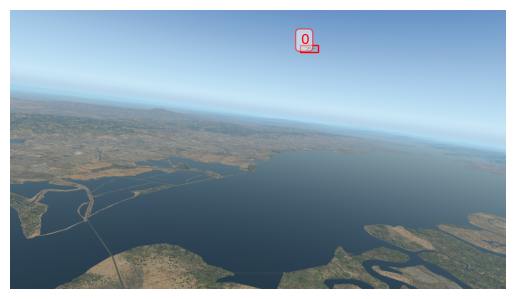

In [92]:
# block to test aug methods

image = '5'
dataset = 'train-aug'
aug_type = 'flip'

test_image_path = f'datasets/cessna_only/images/{dataset}/{image}.jpg'
test_label_path = f'datasets/cessna_only/labels/{dataset}/{image}.txt'

aug_image_path = f'datasets/cessna_only/images/{dataset}/{image}-{aug_type}.jpg'
aug_label_path = f'datasets/cessna_only/labels/{dataset}/{image}-{aug_type}.txt'

overlay_bbox(aug_image_path, aug_label_path)

# Create Augmented Datasets

In [59]:
# save image and label
def save_image(path, image):

    # Ensure the directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Convert from RGB to BGR
    image_to_save = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Save the image
    cv2.imwrite(path, image_to_save)

# save label
def save_label(path, contents):
    # Ensure the directory exists
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    # Now, save the file
    with open(path, 'w') as label_file:
        label_file.write(contents)

In [83]:
# create augmented dataset structure

# remove directories if they exist
def remove_if_exists(path, progress=None):
    if os.path.isdir(path):
        shutil.rmtree(path)
    elif os.path.isfile(path):
        os.remove(path)    
    if progress:
        progress.update(1)
        
## augmented dataset structure
def create_augmented_dataset_structure(original_dataset_path):
  
    # Create train-aug paths
    images_train_aug_path = original_dataset_path + '/images/train-aug'
    labels_train_aug_path = original_dataset_path + '/labels/train-aug'

    dataset_name, _ = os.path.splitext(os.path.basename(original_dataset_path))


    # Path for original and new yaml
    original_yaml_path = original_dataset_path + f'/{dataset_name}.yaml'
    augmented_yaml_path = original_dataset_path + f'/{dataset_name}-aug.yaml'

    paths_to_remove = [
        images_train_aug_path,
        labels_train_aug_path,
        augmented_yaml_path
    ]   

    # Replace existing directories
    with tqdm(total=len(paths_to_remove), desc="Removing existing directories/files") as progress:
        # Check and remove each path, updating progress
        for path in paths_to_remove:
            remove_if_exists(path, progress)

    # Create directories
    os.makedirs(images_train_aug_path, exist_ok=True)
    os.makedirs(labels_train_aug_path, exist_ok=True)
    
    # create new yaml with aug appended to train  
    with open(original_yaml_path, 'r') as file:
        dataset_config = yaml.safe_load(file) 

    dataset_config['train'] += "-aug"

    with open(augmented_yaml_path, 'w') as file:
        yaml.safe_dump(dataset_config, file, default_flow_style=False, sort_keys=False)

In [84]:
# augment datastets

# copies all files to another directory 
def copy_directory_contents_concurrently(src_dir, dst_dir):
     
    # Retrieve a list of source file paths
    src_files = [os.path.join(src_dir, file_name) for file_name in os.listdir(src_dir)]
    dst_files = [os.path.join(dst_dir, os.path.basename(file_path)) for file_path in src_files]
    
    # Copy files concurrently
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        list(tqdm(executor.map(shutil.copy2, src_files, dst_files), total=len(src_files), desc="Copying files"))

# augments and saves individual image and label
def augment_image(image_path, images_aug_dir, label_path, labels_aug_dir, method_name, method_info):
    
    # raw name of image and label without file extension
    image_name, _ = os.path.splitext(os.path.basename(image_path))
    label_name, _ = os.path.splitext(os.path.basename(label_path))

    # throw error if image does not match label
    if image_name != label_name:
        raise ValueError(f"ERROR: Filename mismatch: {image_name} and {label_name} do not match.")

    # create filenames for augmented images
    aug_image_filename = f"{image_name}-{method_name}.jpg"
    aug_label_filename = f"{label_name}-{method_name}.txt"
    
    # Determine which augmentation function to call based on the method name
    if method_name == 'flip':
        augmented_image, augmented_label = augment_flip(image_path, label_path, **method_info['parameters'])
    elif method_name == 'rotation':
        augmented_image, augmented_label = augment_rotation(image_path, label_path, **method_info['parameters'])
    elif method_name == 'brightness_contrast':
        augmented_image = augment_brightness_contrast(image_path, **method_info['parameters'])
        augmented_label = open(label_path).read()  # No change to label for this augmentation
    elif method_name == 'gaussian_noise':
        augmented_image = augment_gaussian_noise(image_path, **method_info['parameters'])
        augmented_label = open(label_path).read()  # No change to label for this augmentation
    elif method_name == 'histogram_equalization':
        augmented_image = augment_histogram_equalization(image_path, **method_info['parameters'])
        augmented_label = open(label_path).read()  # No change to label for this augmentation
    elif method_name == 'white_balance':
        augmented_image = augment_white_balance(image_path)
        augmented_label = open(label_path).read()  # No change to label for this augmentation
    elif method_name == 'sharpen':
        augmented_image = augment_sharpen(image_path)
        augmented_label = open(label_path).read()  # No change to label for this augmentation
    elif method_name == 'zoom':
        augmented_image, augmented_label = augment_zoom(image_path, label_path, **method_info['parameters'])
    
    # Save the augmented image and label
    save_image(images_aug_dir + aug_image_filename, augmented_image)
    save_label(labels_aug_dir + aug_label_filename, augmented_label)



def augment_dataset(original_dataset_path, augmentation_metadata):
    
    # reconstruct dataset with augmentation directories and yaml
    create_augmented_dataset_structure(original_dataset_path)

    # new train directories
    images_dir = original_dataset_path + '/images/train/'
    images_aug_dir = original_dataset_path + '/images/train-aug/'
    labels_dir = original_dataset_path + '/labels/train/'
    labels_aug_dir = original_dataset_path + '/labels/train-aug/'

    copy_directory_contents_concurrently(images_dir, images_aug_dir)
    copy_directory_contents_concurrently(labels_dir, labels_aug_dir)

    # training images 
    image_paths = [os.path.join(images_aug_dir, img_name) for img_name in os.listdir(images_aug_dir)]

    # Apply augmentations based on metadata
    total_augmentations = sum(int(len(image_paths) * info['apply_to_percentage']) for info in augmentation_metadata['methods'].values())
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for method_name, method_info in augmentation_metadata['methods'].items():
            selected_images = random.sample(image_paths, int(len(image_paths) * method_info['apply_to_percentage']))
            selected_labels = [path.replace(images_aug_dir, labels_aug_dir).replace('.jpg', '.txt') for path in selected_images]
            
            for image_path, label_path in zip(selected_images, selected_labels):
                # Schedule the augmentation to be applied concurrently
                futures.append(executor.submit(augment_image, image_path, images_aug_dir, label_path, labels_aug_dir, method_name, method_info))

        # Progress bar for the augmentation tasks
        for _ in tqdm(as_completed(futures), total=total_augmentations, desc="Applying augmentations"):
            pass
    
    # tries and returns error for every image that failed to be augmented - most likely bounding box boundary error
    for future in futures:
        if not future.done():
            print("A future did not complete.")  
        try:
            future.result()  # re-raise exception that occurred
        except Exception as e:
            print(f"An error occurred: {e}")

In [89]:
test_dataset_dir = "datasets/cessna_only"

augmentation_metadata = {
    'methods': {
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.1  # 50% of the training images
        },
        'rotation': {
            'parameters': {
                'angle': 90,  # Rotation angle
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.1  # 30% of the training images
        }
    }
}

augment_dataset(test_dataset_dir, augmentation_metadata)

Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/21600 [00:00<?, ?it/s]

Copying files:   0%|          | 0/21600 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/6480 [00:00<?, ?it/s]

An error occurred: Expected y_max for bbox (0.26918549999999997, 0.7080895, 0.7081584999999999, 1.0007385, 0) to be in the range [0.0, 1.0], got 1.0007385.
An error occurred: Expected y_max for bbox (0.5704404999999999, 0.764508, 0.9682574999999999, 1.02972, 0) to be in the range [0.0, 1.0], got 1.02972.
An error occurred: Expected y_max for bbox (0.45458450000000006, 0.7181775, 0.9206275, 1.0288725, 0) to be in the range [0.0, 1.0], got 1.0288725.


# Test Parameters

In [ ]:
# parameters for each specfic test














# Training